<a href="https://colab.research.google.com/github/juacastanori/TAM/blob/main/Taller_5_Junio/TAM_Conglomerados_Nosup_tanjiroo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##TAM - Juan Jerónimo Castaño Rivera

#Conglomerados no supervisado

# Ejercicios

Para los siguientes puntos, utilizar la librería [RAPIDS](https://rapids.ai/) a la hora de implementar los algoritmos estudiados, en caso de estar disponibles.

- Realice una comparación de los métodos de clustering vistos, para generar una segmentación de imagen a color, incluyendo la información de ubicación de cada pixel (ver Cuaderno guía [tanjiro](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/tanjiro.ipynb)). Varie la cantidad de grupos (niveles o clases de segmentación) $k\in\{3,5,7,9\}$ y presente los scores de inercia y silueta conseguidos.

- Repita el punto anterior realizando una proyección 2D de los datos con PCA y UMAP (ver guía [reducción de dimensión](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/8_ReduccionDimension.ipynb))
 antes de generar las segmentaciones.

**NOTA:** Asegurarse de correr con GPU

Ejercicio 1

In [ ]:
!pip install umap-learn

In [ ]:
# ✅ Descargar imagen Tanjiro
FILEID = "1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O tanjiro.jpeg && rm -rf /tmp/cookies.txt

In [ ]:
# ✅ Importar librerías
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from cuml.cluster import KMeans as cuKMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import pandas as pd

Kmeans

In [ ]:
# ✅ Leer imagen y recortar
image = imread("tanjiro.jpeg")
image = image[50:175, 50:175, :]
plt.imshow(image)
plt.title("Imagen recortada")
plt.axis('off')
plt.show()

# ✅ Dimensiones y extracción de características
r, c, ch = image.shape
X_rgb = image.reshape(-1, 3)

# Coordenadas espaciales
Xc, Xr = np.meshgrid(np.arange(c), np.arange(r))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)

# Dataset completo: [R, G, B, x, y]
X = np.c_[X_rgb, Xc, Xr]
print("Shape del dataset:", X.shape)

# ✅ Escalar datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Configurar clustering con RAPIDS
ks = [3, 5, 7, 9]
results = []

for k in ks:
    print(f"\n🔹 Entrenando cuML KMeans con k = {k}...")
    model = cuKMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)

    inertia = model.inertia_
    silhouette = silhouette_score(X_scaled, labels)

    results.append({
        "k": k,
        "inertia": inertia,
        "silhouette": silhouette
    })

    # ✅ Visualización: coordenadas espaciales
    plt.figure(figsize=(6, 3))
    plt.scatter(X[:, 3], X[:, 4], c=labels, s=1, cmap='tab10')
    plt.title(f"cuML KMeans (k = {k}) - Coordenadas")
    plt.xlabel("Columna")
    plt.ylabel("Fila")
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.show()

    # ✅ Imagen segmentada (colores promedio)
    centroids_rgb = model.cluster_centers_[:, :3]
    segmented_img = centroids_rgb[labels]
    segmented_img = segmented_img.reshape((r, c, 3))

    plt.figure(figsize=(5, 5))
    plt.imshow(segmented_img)
    plt.title(f"Segmentación RGB - cuML KMeans (k = {k})")
    plt.axis('off')
    plt.show()

# ✅ Tabla final
df_results = pd.DataFrame(results)
print("\n📊 Resultados comparativos con RAPIDS cuML:")
display(df_results)


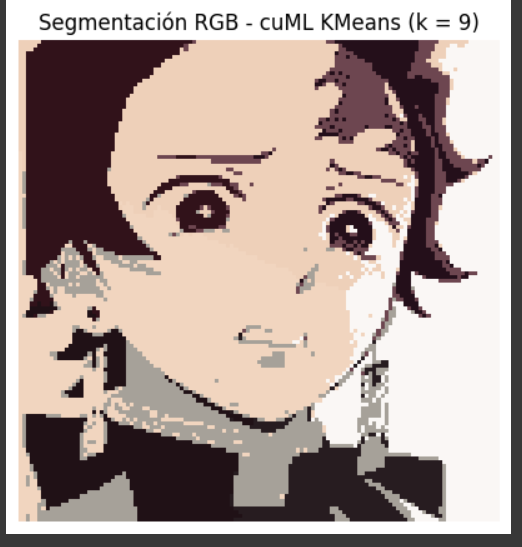

DBSCAN

In [ ]:
from cuml.cluster import DBSCAN as cuDBSCAN

# ✅ Leer imagen y recortar
image = imread("tanjiro.jpeg")
image = image[50:175, 50:175, :]
r, c, ch = image.shape
X_rgb = image.reshape(-1, 3)

# Coordenadas espaciales
Xc, Xr = np.meshgrid(np.arange(c), np.arange(r))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)

# Dataset: [R, G, B, x, y]
X = np.c_[X_rgb, Xc, Xr]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ✅ DBSCAN con RAPIDS cuML
eps_values = [0.05, 0.08, 0.1, 0.12]
results = []

for eps in eps_values:
    print(f"\n🔹 Ejecutando cuML DBSCAN con eps = {eps}...")
    dbscan = cuDBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_scaled)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)

    # Calcular silueta solo si hay más de un clúster
    if n_clusters > 1:
        idx = np.random.choice(len(X_scaled), size=min(2000, len(X_scaled)), replace=False)
        sil = silhouette_score(X_scaled[idx], labels[idx])
    else:
        sil = -1

    results.append({
        "eps": eps,
        "clusters": n_clusters,
        "noise_points": n_noise,
        "silhouette": sil
    })

    # ✅ Visualización de coordenadas
    plt.figure(figsize=(6, 3))
    plt.scatter(X[:, 3], X[:, 4], c=labels, s=1, cmap='tab10')
    plt.title(f"cuML DBSCAN - eps = {eps} ({n_clusters} clústeres)")
    plt.xlabel("Columna")
    plt.ylabel("Fila")
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.show()

    # ✅ Imagen segmentada (promedio RGB por clúster)
    labeled_rgb = np.zeros_like(X_rgb)

    for label in np.unique(labels):
        if label == -1:
            labeled_rgb[labels == label] = [0, 0, 0]  # Ruido = negro
        else:
            labeled_rgb[labels == label] = X_rgb[labels == label].mean(axis=0)

    segmented_img = labeled_rgb.reshape((r, c, 3)).astype(np.uint8)

    plt.figure(figsize=(5, 5))
    plt.imshow(segmented_img)
    plt.title(f"Segmentación cuML DBSCAN - eps = {eps}")
    plt.axis('off')
    plt.show()

# ✅ Tabla de resultados
df_results = pd.DataFrame(results)
print("\n📊 Resultados comparativos DBSCAN (RAPIDS):")
display(df_results)


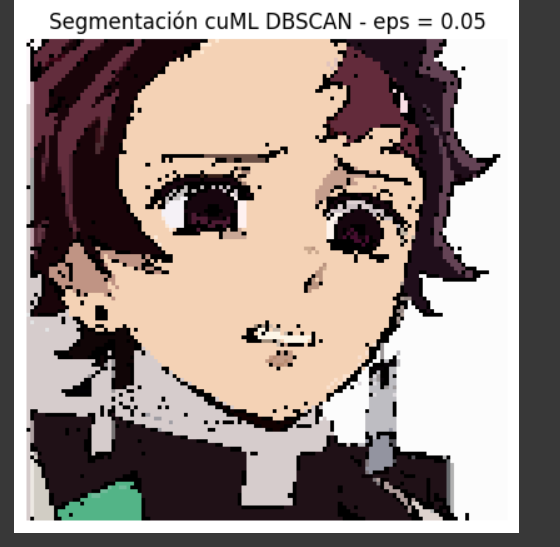

SpecialClustering

In [ ]:
from sklearn.cluster import SpectralClustering

# ✅ Leer y recortar imagen
image = imread("tanjiro.jpeg")
image = image[50:175, 50:175, :]
r, c, ch = image.shape
X_rgb = image.reshape(-1, 3)

# Coordenadas
Xc, Xr = np.meshgrid(np.arange(c), np.arange(r))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)

# Vector completo: R, G, B, x, y
X = np.c_[X_rgb, Xc, Xr]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Parámetros
gamma_values = [1, 5, 10, 20]
n_clusters = 6  # Número fijo para fair comparison
results = []

for gamma in gamma_values:
    print(f"\n🔹 Ejecutando SpectralClustering con gamma = {gamma}...")
    sc = SpectralClustering(n_clusters=n_clusters, gamma=gamma, assign_labels='kmeans', random_state=42)
    labels = sc.fit_predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)

    results.append({
        "gamma": gamma,
        "clusters": n_clusters,
        "silhouette": sil
    })

    # ✅ Gráfico por coordenadas
    plt.figure(figsize=(6, 3))
    plt.scatter(X[:, 3], X[:, 4], c=labels, s=1, cmap='tab10')
    plt.title(f"Spectral Clustering - gamma = {gamma}")
    plt.xlabel("Columna")
    plt.ylabel("Fila")
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.show()

    # ✅ Imagen segmentada por promedio RGB de clúster
    labeled_rgb = np.zeros_like(X_rgb)
    for lbl in np.unique(labels):
        labeled_rgb[labels == lbl] = X_rgb[labels == lbl].mean(axis=0)

    segmented_img = labeled_rgb.reshape((r, c, 3)).astype(np.uint8)
    plt.figure(figsize=(5, 5))
    plt.imshow(segmented_img)
    plt.title(f"Segmentación Spectral - gamma = {gamma}")
    plt.axis('off')
    plt.show()

# ✅ Tabla final
df_results = pd.DataFrame(results)
print("\n📊 Resultados comparativos Spectral Clustering:")
display(df_results)


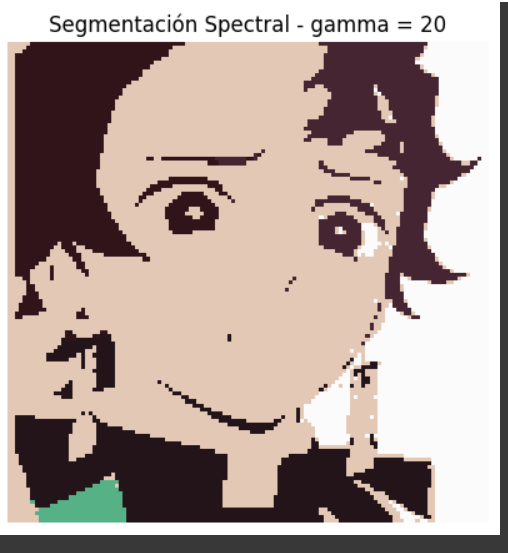

Ejercicio 2

UMAP + DBSCAN

In [ ]:
from cuml.manifold import UMAP as cuUMAP
from cuml.cluster import DBSCAN as cuDBSCAN
import cudf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
import pandas as pd

# ✅ Leer imagen y extraer info
image = imread("tanjiro.jpeg")
image = image[50:175, 50:175, :]
r, c, ch = image.shape
X_rgb = image.reshape(-1, 3)

# Coordenadas
Xc, Xr = np.meshgrid(np.arange(c), np.arange(r))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)

X = np.c_[X_rgb, Xc, Xr]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ✅ UMAP con RAPIDS (usando cudf)
X_cudf = cudf.DataFrame.from_records(X_scaled)
umap_model = cuUMAP(n_components=2, n_neighbors=15, min_dist=0.001, random_state=42)
X_umap = umap_model.fit_transform(X_cudf).to_numpy()

# Visualización de la proyección UMAP
plt.figure(figsize=(6, 4))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=1, c='gray')
plt.title("UMAP - Proyección 2D de datos")
plt.axis('equal')
plt.show()

# ✅ DBSCAN sobre UMAP
eps_values = [0.05, 0.08, 0.1, 0.12]
results = []

for eps in eps_values:
    print(f"\n🔹 Ejecutando cuML DBSCAN con eps = {eps}...")
    dbscan = cuDBSCAN(eps=eps, min_samples=5)

    labels = cudf.Series(dbscan.fit_predict(X_umap)).to_numpy()


    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)

    if n_clusters > 1:
        idx = np.random.choice(len(X_umap), size=min(2000, len(X_umap)), replace=False)
        sil = silhouette_score(X_umap[idx], labels[idx])
    else:
        sil = -1

    results.append({
        "eps": eps,
        "clusters": n_clusters,
        "noise_points": n_noise,
        "silhouette": sil
    })

    # ✅ Visualización: espacio UMAP reducido
    plt.figure(figsize=(6, 4))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, s=1, cmap='tab10')
    plt.title(f"UMAP + DBSCAN - eps = {eps}")
    plt.axis('equal')
    plt.show()

    # ✅ Visualización espacial original (coordenadas columna-fila)
    plt.figure(figsize=(6, 3))
    plt.scatter(X[:, 3], X[:, 4], c=labels, s=1, cmap='tab10')
    plt.title(f"Coordenadas espaciales - eps = {eps}")
    plt.xlabel("Columna")
    plt.ylabel("Fila")
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.show()

    # ✅ Reconstrucción segmentada
    labeled_rgb = np.zeros_like(X_rgb)
    for label in np.unique(labels):
        if label == -1:
            labeled_rgb[labels == label] = [0, 0, 0]
        else:
            labeled_rgb[labels == label] = X_rgb[labels == label].mean(axis=0)

    segmented_img = labeled_rgb.reshape((r, c, 3)).astype(np.uint8)

    plt.figure(figsize=(5, 5))
    plt.imshow(segmented_img)
    plt.title(f"Segmentación - UMAP + DBSCAN (eps = {eps})")
    plt.axis('off')
    plt.show()

# ✅ Tabla resumen
df_results = pd.DataFrame(results)
print("\n📊 Resultados comparativos - UMAP + cuML DBSCAN:")
display(df_results)


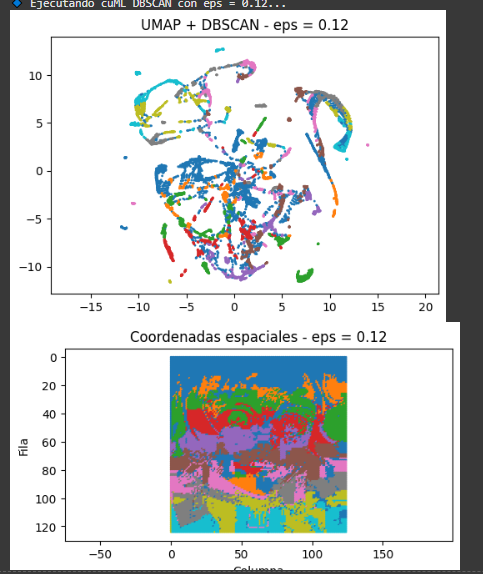

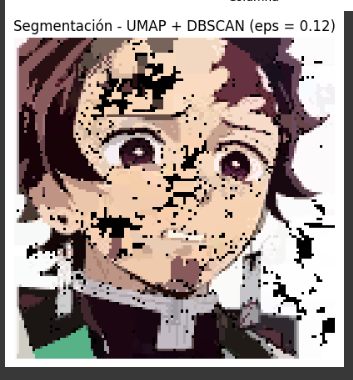

UMAP + K-means

In [ ]:
from cuml.manifold import UMAP as cuUMAP
from cuml.cluster import KMeans as cuKMeans
import cudf

# ✅ Leer imagen y datos
image = imread("tanjiro.jpeg")
image = image[50:175, 50:175, :]
r, c, ch = image.shape
X_rgb = image.reshape(-1, 3)

# Coordenadas
Xc, Xr = np.meshgrid(np.arange(c), np.arange(r))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)

X = np.c_[X_rgb, Xc, Xr]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Proyección UMAP
X_cudf = cudf.DataFrame.from_records(X_scaled)
umap_model = cuUMAP(n_components=2, n_neighbors=30, min_dist=0.9, random_state=42)
X_umap = umap_model.fit_transform(X_cudf).to_numpy()

# Visualizar proyección UMAP
plt.figure(figsize=(6, 4))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=1, c='gray')
plt.title("Proyección UMAP (2D)")
plt.axis('equal')
plt.show()

# ✅ Clustering KMeans en espacio UMAP
ks = [3, 6, 9, 12]
results = []

for k in ks:
    print(f"\n🔹 Ejecutando KMeans (k = {k}) en espacio UMAP...")
    model = cuKMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_umap)
    if hasattr(labels, 'to_numpy'):
        labels = labels.to_numpy()

    inertia = model.inertia_
    silhouette = silhouette_score(X_umap, labels)

    results.append({
        "k": k,
        "inertia": inertia,
        "silhouette": silhouette
    })

    # Visualización en UMAP
    plt.figure(figsize=(6, 4))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, s=1, cmap='tab10')
    plt.title(f"UMAP + KMeans - k = {k}")
    plt.axis('equal')
    plt.show()

    # Visualización espacial
    plt.figure(figsize=(6, 3))
    plt.scatter(X[:, 3], X[:, 4], c=labels, s=1, cmap='tab10')
    plt.title(f"Coordenadas espaciales - k = {k}")
    plt.xlabel("Columna")
    plt.ylabel("Fila")
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.show()

    # Reconstrucción segmentada RGB
    labeled_rgb = np.zeros_like(X_rgb)
    for lbl in np.unique(labels):
        labeled_rgb[labels == lbl] = X_rgb[labels == lbl].mean(axis=0)
    segmented_img = labeled_rgb.reshape((r, c, 3)).astype(np.uint8)

    plt.figure(figsize=(5, 5))
    plt.imshow(segmented_img)
    plt.title(f"Segmentación RGB - UMAP + KMeans (k = {k})")
    plt.axis('off')
    plt.show()

# ✅ Tabla resumen
df_results = pd.DataFrame(results)
print("\n📊 Resultados comparativos - UMAP + cuML KMeans:")
display(df_results)


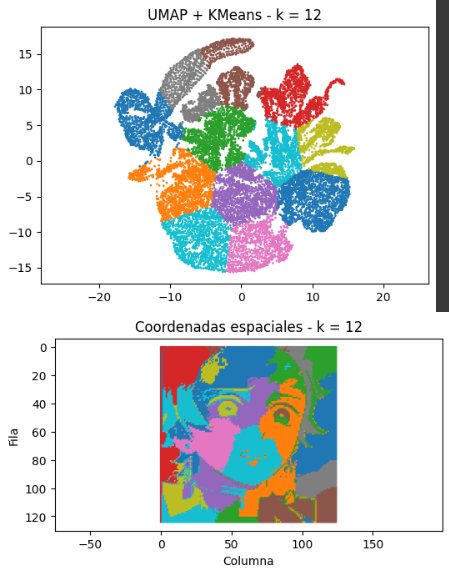

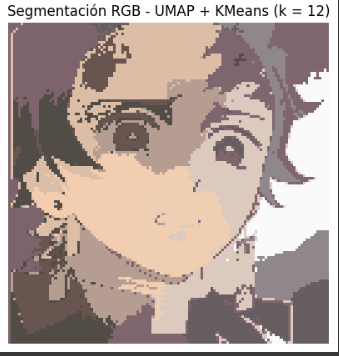

In [ ]:
#https://drive.google.com/file/d/1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP/view?usp=sharing

FILEID = "1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O tanjiro.jpeg && rm -rf /tmp/cookies.txt

UMAP + K-means  (Como en el cuaderno original)

In [ ]:
from umap import UMAP
from sklearn.cluster import KMeans
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np

image = imread(os.path.join("tanjiro.jpeg"))
image = image[50:175,50:175,:]
plt.imshow(image)
image.shape

X = image.reshape(-1, 3)
r,c,ch = image.shape
print(r,c,ch)

vr = np.linspace(0,r,r,endpoint=False)
vc = np.linspace(0,c,c,endpoint=False)
Xc = np.kron(np.ones((r,1)),vc.reshape(-1,1))
Xr = np.kron(vr.reshape(-1,1),np.ones((1,c)))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)
X = np.c_[X,Xc,Xr]
X.shape

plt.pcolormesh(X)
plt.colorbar()
plt.show()

scaler = MinMaxScaler()

X_ = scaler.fit_transform(X)
X_ = PCA(n_components=2).fit_transform(X_)
plt.scatter(X_[:,0], X_[:,1], c=X[:,2])
plt.show()

X_ = scaler.fit_transform(X)
X_ = UMAP(n_components=2,n_neighbors = 30,#round(np.sqrt(X_.shape[0])),
          min_dist =0.9).fit_transform(X_)

kmeans = KMeans(n_clusters=4,n_init='auto').fit(X_)
kmeans.labels_

plt.scatter(X_[:,0], X_[:,1], c=kmeans.labels_)

plt.colorbar()
plt.show()

labels_ = kmeans.labels_
Ilabels = labels_.reshape(r,c)
plt.imshow(Ilabels)
plt.colorbar()
plt.show()

D_ = kmeans.transform(X_)
D_.shape
ind_ = np.argmin(D_,axis=0)

D_.shape
ind_

centroids_ = X[ind_,:3]
centroids_


segmented_img = centroids_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)
plt.imshow(segmented_img/255.)

plt.show()

Comparación UMAP vs PCA

In [ ]:
# === IMPORTAR LIBRERÍAS ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from cuml.manifold import UMAP as cuUMAP
from cuml.cluster import KMeans as cuKMeans
import cudf
import os

# === DESCARGAR IMAGEN TANJIRO ===
FILEID = "1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP"
FILENAME = "tanjiro.jpeg"
if not os.path.exists(FILENAME):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O tanjiro.jpeg && rm -rf /tmp/cookies.txt

# === LEER Y PROCESAR IMAGEN ===
image = imread("tanjiro.jpeg")
image = image[50:175, 50:175, :]
r, c, ch = image.shape
X_rgb = image.reshape(-1, 3)

# Coordenadas espaciales
Xc, Xr = np.meshgrid(np.arange(c), np.arange(r))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)

# Dataset con pesos ajustados
X = np.c_[X_rgb * 0.5, Xc.reshape(-1, 1) * 2.0, Xr.reshape(-1, 1) * 2.0]

# === PCA PREVIO A UMAP ===
X_pca = PCA(n_components=5).fit_transform(X)
X_scaled = MinMaxScaler().fit_transform(X_pca)
X_cudf = cudf.DataFrame.from_records(X_scaled)

# === PROYECCIÓN UMAP ===
umap_model = cuUMAP(n_components=2, n_neighbors=20, min_dist=0.05, random_state=42)
X_umap = umap_model.fit_transform(X_cudf).to_numpy()

# === KMEANS SOBRE UMAP ===
k = 9
kmeans_umap = cuKMeans(n_clusters=k, random_state=42)
labels_umap = kmeans_umap.fit_predict(X_umap)

# === RECONSTRUIR IMAGEN SEGMENTADA (UMAP) ===
X_rgb_original = image.reshape(-1, 3)
labeled_rgb_umap = np.zeros_like(X_rgb_original)
for label in np.unique(labels_umap):
    labeled_rgb_umap[labels_umap == label] = X_rgb_original[labels_umap == label].mean(axis=0)
img_segmented_umap = labeled_rgb_umap.reshape((r, c, 3)).astype(np.uint8)

# === PCA DIRECTO SIN UMAP ===
X_direct = MinMaxScaler().fit_transform(np.c_[X_rgb, Xc, Xr])
X_pca_direct = PCA(n_components=2).fit_transform(X_direct)

kmeans_pca = cuKMeans(n_clusters=k, random_state=42)
labels_pca = kmeans_pca.fit_predict(X_pca_direct)

# === RECONSTRUIR IMAGEN SEGMENTADA (PCA) ===
labeled_rgb_pca = np.zeros_like(X_rgb_original)
for label in np.unique(labels_pca):
    labeled_rgb_pca[labels_pca == label] = X_rgb_original[labels_pca == label].mean(axis=0)
img_segmented_pca = labeled_rgb_pca.reshape((r, c, 3)).astype(np.uint8)

# === MOSTRAR RESULTADOS COMPARATIVOS ===
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img_segmented_umap)
axs[0].set_title("UMAP + cuML KMeans (k=9)")
axs[0].axis('off')
axs[1].imshow(img_segmented_pca)
axs[1].set_title("PCA + cuML KMeans (k=9)")
axs[1].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Requiere que ya tengas las variables: image, r, c, X_rgb, Xc, Xr

from sklearn.metrics import silhouette_score
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convertir etiquetas de cuML a NumPy
labels_umap_np = labels_umap
labels_pca_np = labels_pca

# === Calcular métricas ===
inertia_umap = kmeans_umap.inertia_
silhouette_umap = silhouette_score(X_umap, labels_umap_np)

inertia_pca = kmeans_pca.inertia_
silhouette_pca = silhouette_score(X_pca_direct, labels_pca_np)

# === Mostrar etiquetas de clúster (coloreadas) ===
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(labels_umap_np.reshape(r, c), cmap='viridis')
axs[0].set_title("Etiquetas UMAP + cuML KMeans")
axs[0].axis('off')

axs[1].imshow(labels_pca_np.reshape(r, c), cmap='viridis')
axs[1].set_title("Etiquetas PCA + cuML KMeans")
axs[1].axis('off')
plt.tight_layout()
plt.show()

# === Tabla comparativa de métricas ===
df_comp = pd.DataFrame({
    "Método": ["UMAP + KMeans", "PCA + KMeans"],
    "Inercia": [inertia_umap, inertia_pca],
    "Silhouette": [silhouette_umap, silhouette_pca]
})

# === Graficar tabla con colores ===
plt.figure(figsize=(7, 2))
sns.heatmap(df_comp.set_index("Método"), annot=True, cmap="YlGnBu", fmt=".4f", cbar=False)
plt.title("📊 Comparación de UMAP vs PCA con cuML KMeans")
plt.tight_layout()
plt.show()


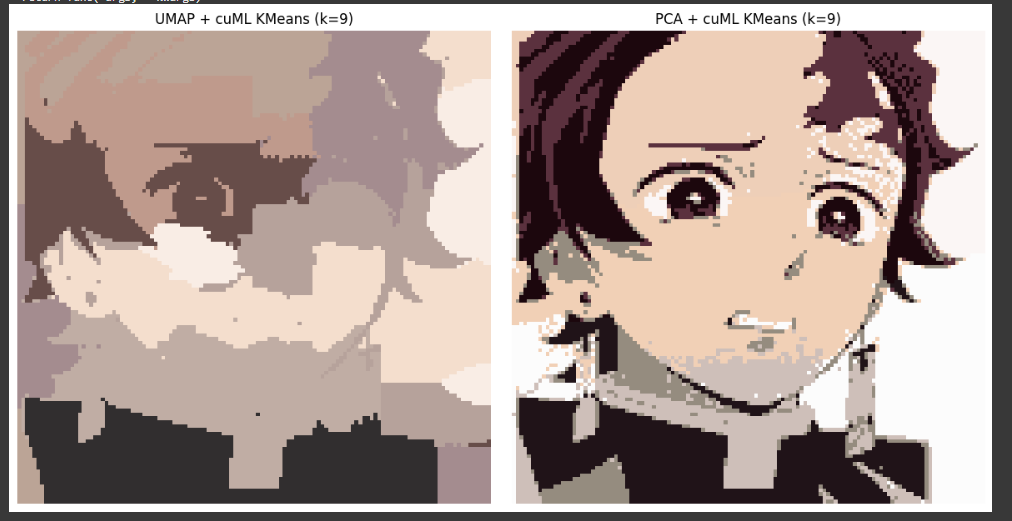

Se puede observar que para este caso, funciona mejor PCA.

Puede deberse a que PCA es una técnica lineal que busca encontrar las direcciones de máxima varianza en los datos, mientras que UMAP es una técnica no lineal que preserva la estructura local de los datos en el espacio reducido.

Se puede decir que esta imagen tiene direcciones lineales, que hacen que sea mejor opcion implementar PCA